In [195]:
import json
import os

results_dir = "results/"
json_files = [pos_json for pos_json in os.listdir(results_dir) if pos_json.endswith('.json')]

data = []
for index, json_fn in enumerate(json_files):
    with open(os.path.join(results_dir, json_fn)) as in_file:
        fusion_group = json_fn.removesuffix('.json')
        content = json.load(in_file)
        print(f'Read fusion group {fusion_group} with {len(content)} lines')
        data.extend(content)

Read fusion group AS,CA.DJ,CS.CSA.CSL,CT,CW,I,SE with 7676 lines
Read fusion group AS,CA.DJ,CS,CSA,CSL,CT,CW,I,SE with 9543 lines
Read fusion group AS,CA.DJ,CS.CSA.CSL,CT,CW.I.SE with 11577 lines
Read fusion group AS,CA.DJ,CS.CSA,CSL,CT,CW,I,SE with 8665 lines
Read fusion group AS,CA.DJ,CS.CSA.CSL,CT,CW.SE,I with 7701 lines
Read fusion group AS,CA,CS,CSA,CSL,CT,CW,DJ,I,SE with 10479 lines


In [196]:
# This is a single invocation
# data[0]

In [197]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.DataFrame.from_dict(data)

# Get the smallest Start timestamp and remove it from every timestamp value
min_start_timestamp = df["startTimestamp"].min()
df["startTimestamp"] = df["startTimestamp"] - min_start_timestamp
df["endTimestamp"] = df["endTimestamp"] - min_start_timestamp
df["duration"] =  df["endTimestamp"] - df["startTimestamp"]
df["fusionGroup"] = df["fusionGroup"].str.replace(",", "/")

df

,traceId,fusionGroup,source,currentFunction,billedDuration,maxMemoryUsed,isRootInvocation,startTimestamp,endTimestamp,internalDuration,calls,duration
0,fcdf7084f278fdbd3da171767317ad648987cb46de72ff...,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,I,AS,245,97,False,3627924,3628166,223,"[{'called': 'AS', 'caller': 'AS', 'local': Tru...",242
1,105cf38ffae13f6b3a657800bf1dc9aeddf10435268951...,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,I,AS,2,97,False,3628551,3628552,0,"[{'called': 'AS', 'caller': 'AS', 'local': Tru...",1
2,105cf38ffae13f6b3a657800bf1dc9aeddf10435268951...,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,I,AS,222,97,False,3629165,3629387,220,"[{'called': 'AS', 'caller': 'AS', 'local': Tru...",222
3,399ffeb013df0d34cde36565ac7d68a3edde0fd1bcd07f...,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,I,AS,2,97,False,3629581,3629582,0,"[{'called': 'AS', 'caller': 'AS', 'local': Tru...",1
4,399ffeb013df0d34cde36565ac7d68a3edde0fd1bcd07f...,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,I,AS,203,97,False,3629885,3630087,201,"[{'called': 'AS', 'caller': 'AS', 'local': Tru...",202
...,...,...,...,...,...,...,...,...,...,...,...,...
55636,70d422630d4f38ef33390e9df91b719f13d67c86d432a6...,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,I,SE,65,91,False,521365,521430,63,"[{'called': 'SE', 'caller': 'SE', 'local': Tru...",65
55637,e5987ef0a9bef9da8023f1e5d8ee026d1f6866782caa28...,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,I,SE,41,91,False,522420,522461,39,"[{'called': 'SE', 'caller': 'SE', 'local': Tru...",41
55638,519549ddb14da61b318c9041735db80dc3c94ccad44f47...,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,I,SE,43,91,False,523405,523447,41,"[{'called': 'SE', 'caller': 'SE', 'local': Tru...",42
55639,d9897228d272108e4960f239f8091d4f577b678a92fdbf...,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,I,SE,69,91,False,524419,524487,67,"[{'called': 'SE', 'caller': 'SE', 'local': Tru...",68


In [198]:
print(f'Unique Invocations: {df["traceId"].nunique()}')

Unique Invocations: 6999


<AxesSubplot:ylabel='billedDuration'>

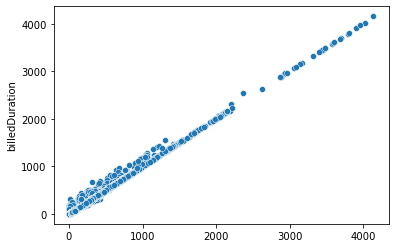

In [199]:
sns.scatterplot(data=df, x=df["endTimestamp"]-df["startTimestamp"], y="billedDuration")

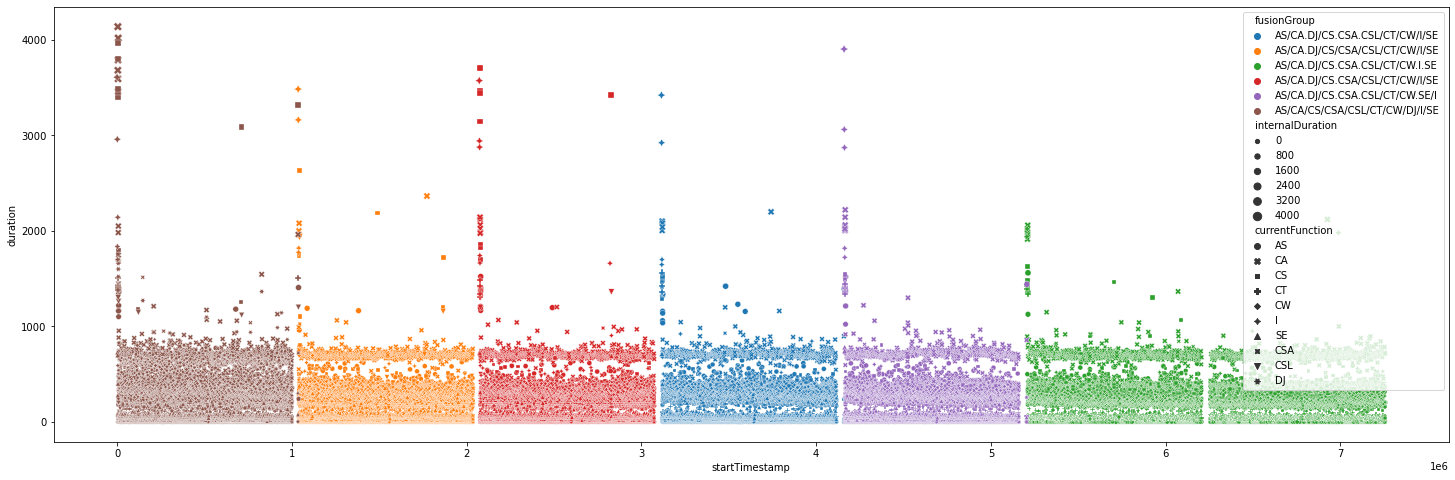

In [200]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=df, x="startTimestamp", y="duration", size="internalDuration", hue=df["fusionGroup"], style="currentFunction")
plt.savefig("pointCloud.pdf")

<AxesSubplot:xlabel='startTimestamp', ylabel='10s_billedDuration_avg'>

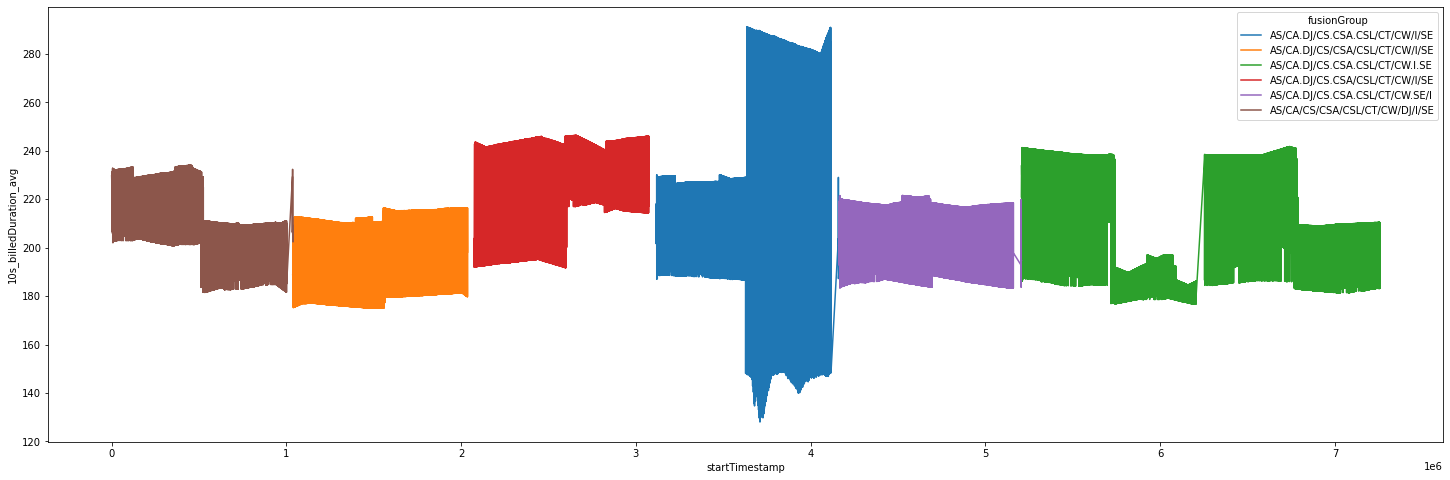

In [201]:
plt.figure(figsize=(25,8))
df['10s_billedDuration_avg'] = df['billedDuration'].rolling(10000, min_periods=30).mean()
#df['10s_billedDuration_med'] = df['billedDuration'].rolling(10000, min_periods=30).median()
sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_avg", hue=df["fusionGroup"])
#sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_med", hue=df["fusionGroup"])
#sns.scatterplot(data=df, x="startTimestamp", y="billedDuration", hue=df["fusionGroup"], legend=None)

In [202]:
# Now do not count every invocation, but sort the df by the cost of trace
grouped = df.groupby('traceId').agg({'billedDuration': ['sum'], 'startTimestamp': ['min'], 'endTimestamp': ['max'], 'fusionGroup': 'min'})
#grouped['numInvocations'] = df.groupby('traceId').count()
grouped['numInvocations'] = df.groupby('traceId').size()
print(f'Total Number of Invocations should be: {grouped["numInvocations"].sum()} == {len(df.index)}')

# Grouped: Get Root Invocation of TraceId and get rootEndTimestamp
# Pandas join() oder merge() machen mit dem alten Dataframe. Merge ist einfacher
rootInvocations = df[df["isRootInvocation"]][["traceId", "endTimestamp"]].rename(columns={"endTimestamp": "rootEndTimestamp"})
grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")
grouped["rootDuration"] = grouped["rootEndTimestamp"] - grouped["startTimestamp", "min"]

grouped

Total Number of Invocations should be: 55641 == 55641


/tmp/ipykernel_196947/2807751757.py:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


,traceId,"(billedDuration, sum)","(startTimestamp, min)","(endTimestamp, max)","(fusionGroup, min)","(numInvocations, )",rootEndTimestamp,rootDuration
0,000a875886556a886b594f6bde1c465d018ac54153eaca...,2090,342990,344030,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,11,343386.0,396.0
1,0024b18706df23023bbf5eadc4b327f35617301b756e4c...,2226,114508,115686,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,11,114872.0,364.0
2,0036aca1e6fb2b6a4b1a40b4ec16d245df3fa13a60a35a...,1486,1062580,1063544,AS/CA.DJ/CS/CSA/CSL/CT/CW/I/SE,10,1062863.0,283.0
3,004c2cc27f3d6bfd4eb6d4b083340397a50090e6976d20...,1983,2097802,2099156,AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE,9,2098137.0,335.0
4,0055cb4e0817c2126ab451413c183aec6c5cb7bb078c4b...,1351,6431912,6433009,AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE,5,6432086.0,174.0
...,...,...,...,...,...,...,...,...
6994,ffd40c2a38426c3dd50f72a89d8197fb0d2c2ada254f26...,1771,3773537,3775010,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,7,3773923.0,386.0
6995,ffe1d442820b946e57253a1c09dd1ee8476f009580903b...,1597,2236116,2237158,AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE,9,2236416.0,300.0
6996,ffe26acd0d3c57c36c824e1507283e68b91d505d81cafe...,2645,561464,562934,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,11,561977.0,513.0
6997,ffe690bb093171d227834604604b130075cb0f1321b984...,2742,206720,208088,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,11,207024.0,304.0


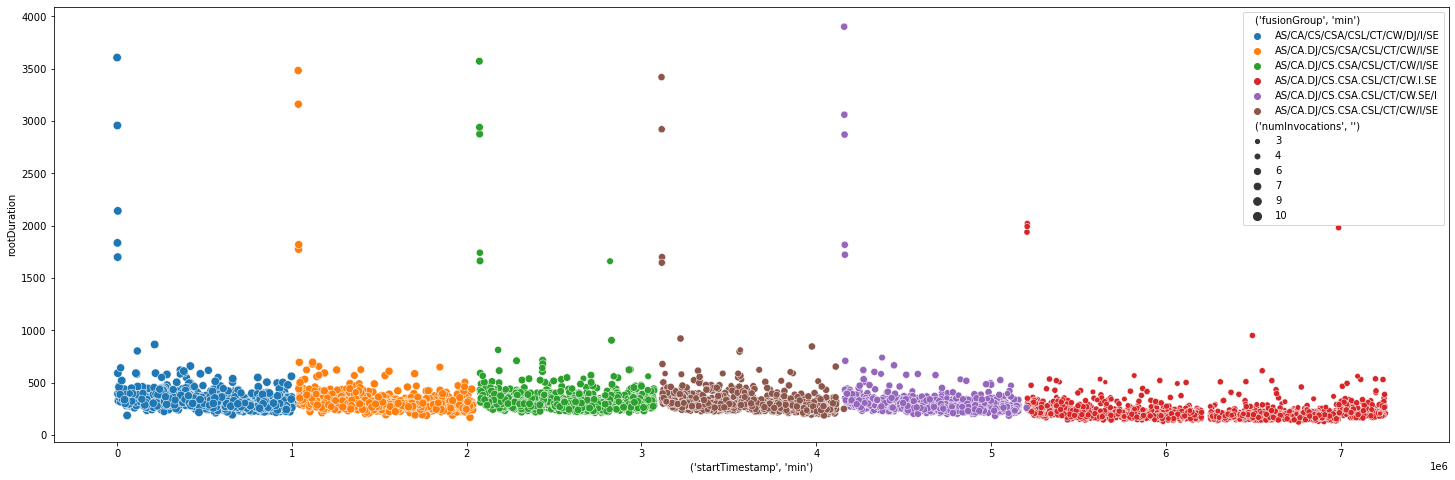

In [203]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("duration.pdf")

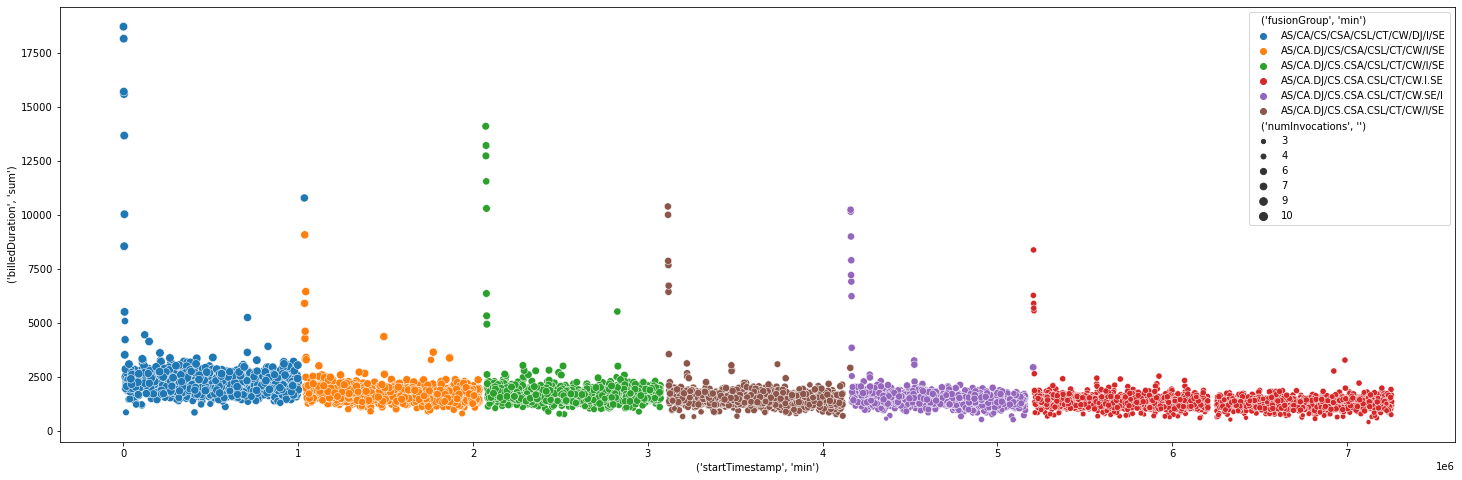

In [204]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("billed.pdf")

In [205]:
grouped[grouped["rootDuration"] <= 1000]

,traceId,"(billedDuration, sum)","(startTimestamp, min)","(endTimestamp, max)","(fusionGroup, min)","(numInvocations, )",rootEndTimestamp,rootDuration
0,000a875886556a886b594f6bde1c465d018ac54153eaca...,2090,342990,344030,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,11,343386.0,396.0
1,0024b18706df23023bbf5eadc4b327f35617301b756e4c...,2226,114508,115686,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,11,114872.0,364.0
2,0036aca1e6fb2b6a4b1a40b4ec16d245df3fa13a60a35a...,1486,1062580,1063544,AS/CA.DJ/CS/CSA/CSL/CT/CW/I/SE,10,1062863.0,283.0
3,004c2cc27f3d6bfd4eb6d4b083340397a50090e6976d20...,1983,2097802,2099156,AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE,9,2098137.0,335.0
4,0055cb4e0817c2126ab451413c183aec6c5cb7bb078c4b...,1351,6431912,6433009,AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE,5,6432086.0,174.0
...,...,...,...,...,...,...,...,...
6994,ffd40c2a38426c3dd50f72a89d8197fb0d2c2ada254f26...,1771,3773537,3775010,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,7,3773923.0,386.0
6995,ffe1d442820b946e57253a1c09dd1ee8476f009580903b...,1597,2236116,2237158,AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE,9,2236416.0,300.0
6996,ffe26acd0d3c57c36c824e1507283e68b91d505d81cafe...,2645,561464,562934,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,11,561977.0,513.0
6997,ffe690bb093171d227834604604b130075cb0f1321b984...,2742,206720,208088,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,11,207024.0,304.0


['AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE' 'AS/CA.DJ/CS/CSA/CSL/CT/CW/I/SE'
 'AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE' 'AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE'
 'AS/CA.DJ/CS.CSA.CSL/CT/CW.SE/I' 'AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE']


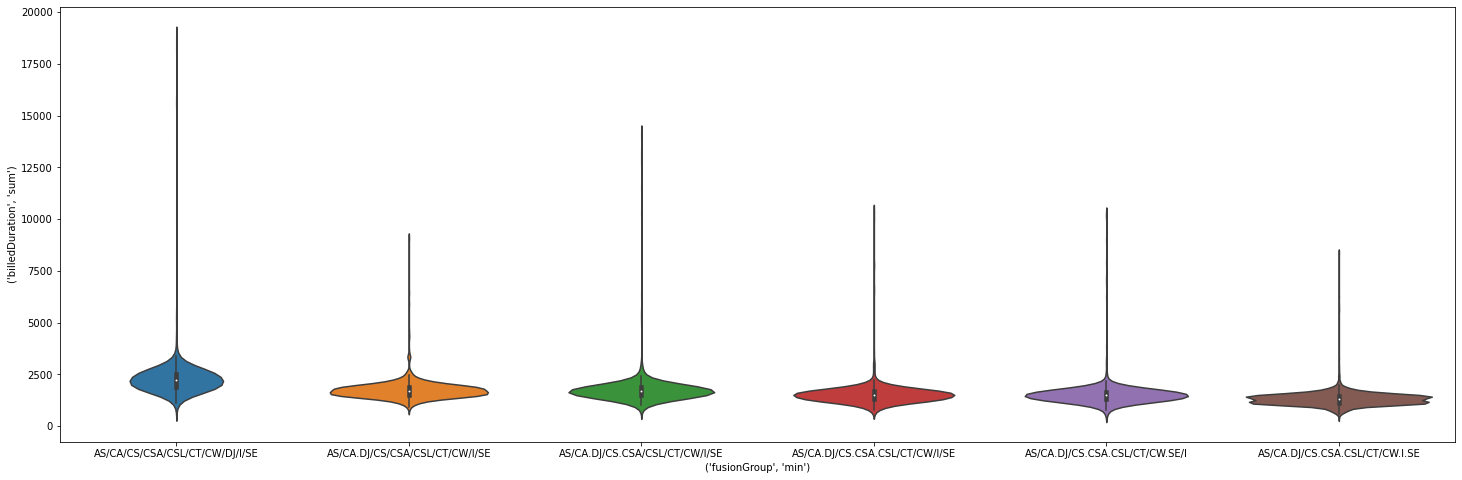

In [206]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['billedDuration', 'sum'], order=fusion_groups_order)
plt.savefig("violinBilled.pdf")

['AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE' 'AS/CA.DJ/CS/CSA/CSL/CT/CW/I/SE'
 'AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE' 'AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE'
 'AS/CA.DJ/CS.CSA.CSL/CT/CW.SE/I' 'AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE']


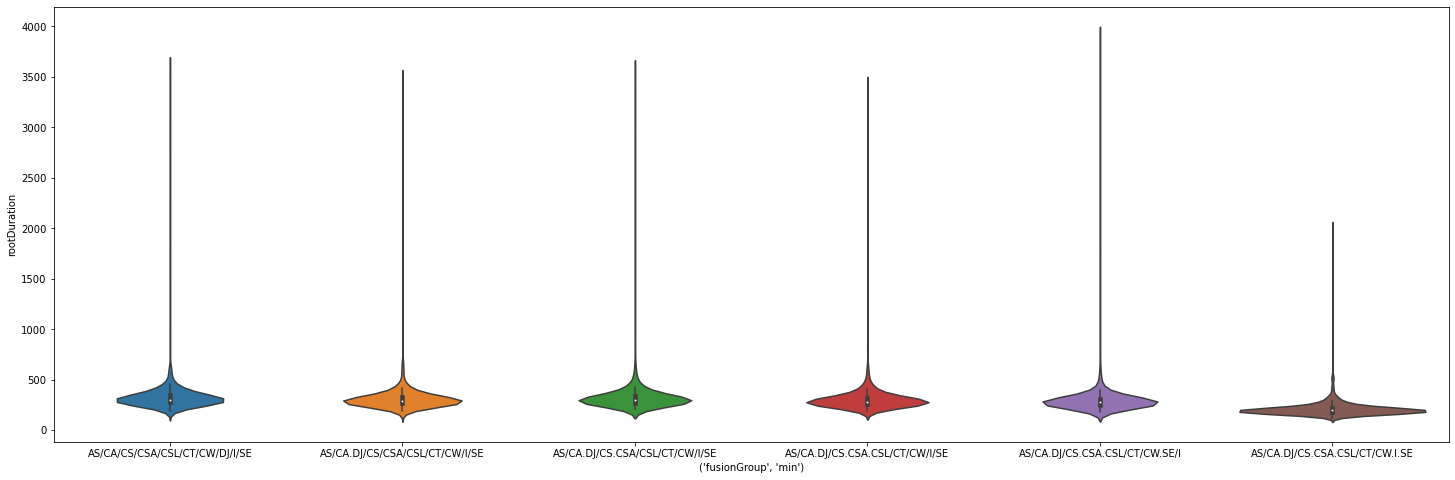

In [207]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['rootDuration'], order=fusion_groups_order)
plt.savefig("violinRR.pdf")

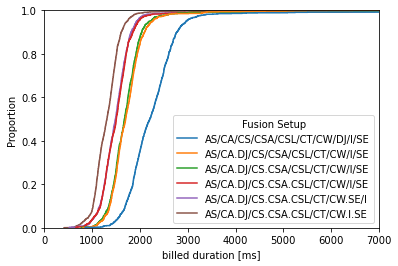

In [213]:
ax = sns.ecdfplot(data=grouped, x=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order)
plt.xlabel("billed duration [ms]")
ax.get_legend().set_title("Fusion Setup")
ax.set(xlim=(000,7000))
plt.savefig("ecdfBilled.pdf")

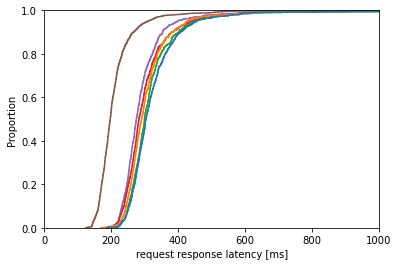

In [215]:
ax = sns.ecdfplot(data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order, legend=None)
plt.xlabel("request response latency [ms]")
#ax.get_legend().set_title("Fusion Group")
ax.set(xlim=(00,1000))
plt.savefig("ecdfRR.pdf")

In [210]:
from scipy.stats import t

In [211]:
# Calculate Mean and Confidence Interval of billed duration and rootDuration

def printMeanAndCi(x, name=""):
    m = x.mean() 
    s = x.std() 
    dof = len(grouped)-1 
    confidence = 0.95

    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    print(f'Mean: {m:7.2f}, Confidence Interval: ({m-s*t_crit/np.sqrt(len(x)):7.2f} / {m+s*t_crit/np.sqrt(len(x)):7.2f}), Median: {x.median()} for {name}')

print("overall")
printMeanAndCi(grouped["rootDuration"], "rootDuration")
printMeanAndCi(grouped['billedDuration', 'sum'], "billedDuration")
for group in fusion_groups_order:
    filtered = grouped[grouped['fusionGroup', 'min'] == group]
    print(group)
    printMeanAndCi(filtered["rootDuration"], f'rootDuration')
    printMeanAndCi(filtered['billedDuration', 'sum'], f'billedDuration')

overall
Mean:  286.74, Confidence Interval: ( 282.86 /  290.62), Median: 273.0 for rootDuration
Mean: 1649.16, Confidence Interval: (1631.19 / 1667.12), Median: 1543.0 for billedDuration
AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE
Mean:  331.83, Confidence Interval: ( 320.87 /  342.79), Median: 304.0 for rootDuration
Mean: 2322.08, Confidence Interval: (2248.74 / 2395.42), Median: 2207.0 for billedDuration
AS/CA.DJ/CS/CSA/CSL/CT/CW/I/SE
Mean:  314.61, Confidence Interval: ( 304.14 /  325.08), Median: 291.0 for rootDuration
Mean: 1744.58, Confidence Interval: (1715.39 / 1773.77), Median: 1703.0 for billedDuration
AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE
Mean:  328.03, Confidence Interval: ( 316.44 /  339.61), Median: 300.0 for rootDuration
Mean: 1754.82, Confidence Interval: (1702.09 / 1807.55), Median: 1678.0 for billedDuration
AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE
Mean:  309.79, Confidence Interval: ( 299.77 /  319.81), Median: 283.0 for rootDuration
Mean: 1542.33, Confidence Interval: (1504.60 / 1580.05), Median: